In [32]:
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpld3 
import seaborn as sns
# import palettable.colorbrewer.diverging as pld
import palettable.mycarta as pld
# import palettable.matplotlib as pld

import numpy as np
import pandas as pd
from sklearn import preprocessing

from scipy import integrate  
#import scipy.signal as scipy
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

%matplotlib widget

In [40]:
plt.close('all')

In [41]:
## Plotting parameters

# palette = pld.RdYlGn_4_r
palette = pld.CubeYF_3
# palette = pld.Viridis_20_r
cmap = palette.mpl_colormap
transparency = 0.7
labelsize = 20
spinewidth = 3
fontsize = 26
legendsize = 20
fontweight = 'bold'
labelpad = 6
pad = 10
linewidth = 2.5


In [42]:
## Find the subfolders in the current working folder (cwd)
#cwd = os.getcwd()
cwd = '/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20220630_CHLin'
subfolder = glob.glob(cwd + '/CsPbBr**')
subfolder.sort()
print(*subfolder, sep = '\n')  ## Print one element per line

/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20220630_CHLin/CsPbBr_100uL
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20220630_CHLin/CsPbBr_100uL_I_08uL
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20220630_CHLin/CsPbBr_100uL_I_16uL
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20220630_CHLin/CsPbBr_100uL_I_32uL
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20220630_CHLin/CsPbBr_100uL_I_64uL


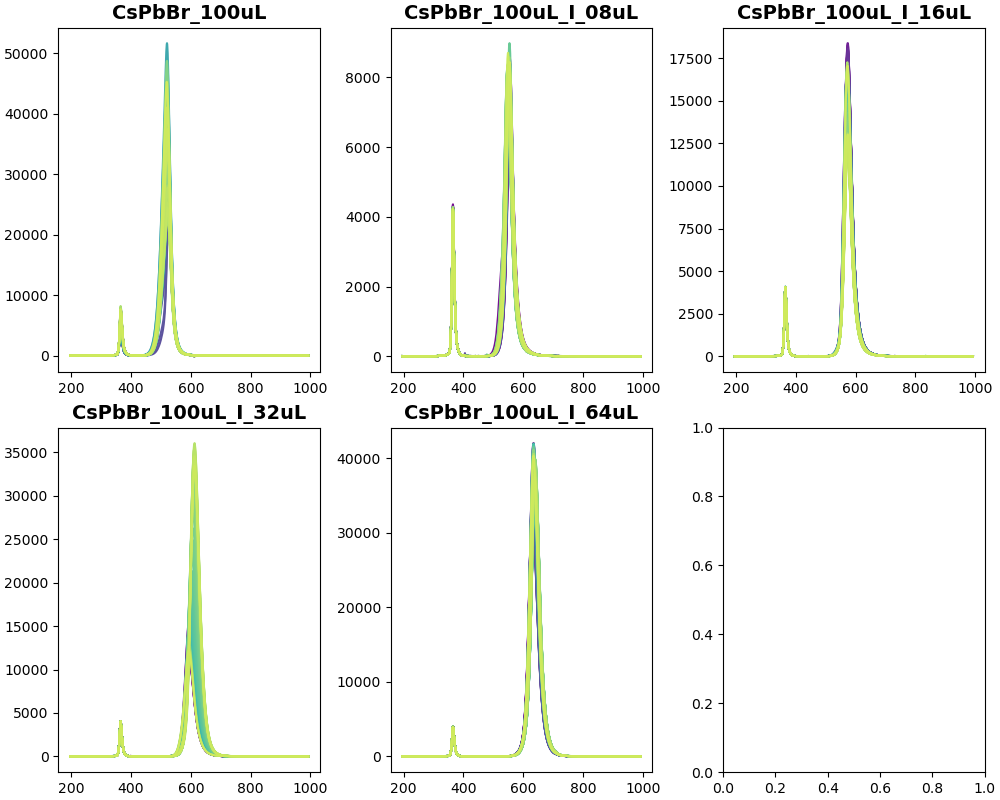

In [53]:
## Plot All PL profiles in each subfolder
f1, ax1 = plt.subplots(2, int(len(subfolder)/2)+1, figsize = (10, 8), constrained_layout=True)
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

ax1 = ax1.flatten()
df = pd.DataFrame()
df_norm = pd.DataFrame()
df_norm2 = pd.DataFrame()

## Wavelength range
w1 = 250
w2 = 750

for i in range(len(subfolder)):
# for i in range(1):
    data_files = glob.glob(subfolder[i] + '/**Subt**.txt')
    data_files.sort()
    k1 = 0
    k2 = len(data_files)
    color_idx = np.linspace(0, 1, k2-k1+1)
    ax1[i].set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})
    df_i = pd.DataFrame()
    for j in range(k1, k2):
        df_j = pd.read_csv(data_files[j], names=['wavelength', 'intensity'], skiprows=14, sep='\t')
        ax1[i].plot(df_j.wavelength, df_j.intensity, color=cmap(color_idx[j-k1]))
        #df_i[f'Iten_{j}'] = df_j.intensity
        df_i = pd.concat([df_i, df_j.intensity], axis=1, ignore_index=True)
    
    df[f'{os.path.basename(subfolder[i])}']= df_i.mean(axis=1)
    #df_norm[f'{os.path.basename(subfolder[i])}']= df_i.mean(axis=1) / df_i.mean(axis=1).sum(axis=0)
    df_norm[f'{os.path.basename(subfolder[i])}']= df[f'{os.path.basename(subfolder[i])}'].loc[w1:w2] / df[f'{os.path.basename(subfolder[i])}'].loc[w1:w2].sum(axis=0)
    
    x = df[f'{os.path.basename(subfolder[i])}'].loc[w1:w2].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    df_norm2[f'{os.path.basename(subfolder[i])}']= x_scaled.flatten()

    
df['wavelength'] = df_j.wavelength
df_norm['wavelength'] = df_j.wavelength.loc[w1:w2]
#df_norm2['wavelength'] = df_j.wavelength.loc[w1:w2]
df_norm2.loc[0:w2-w1, 'wavelength'] = df_j.wavelength.loc[w1:w2].values

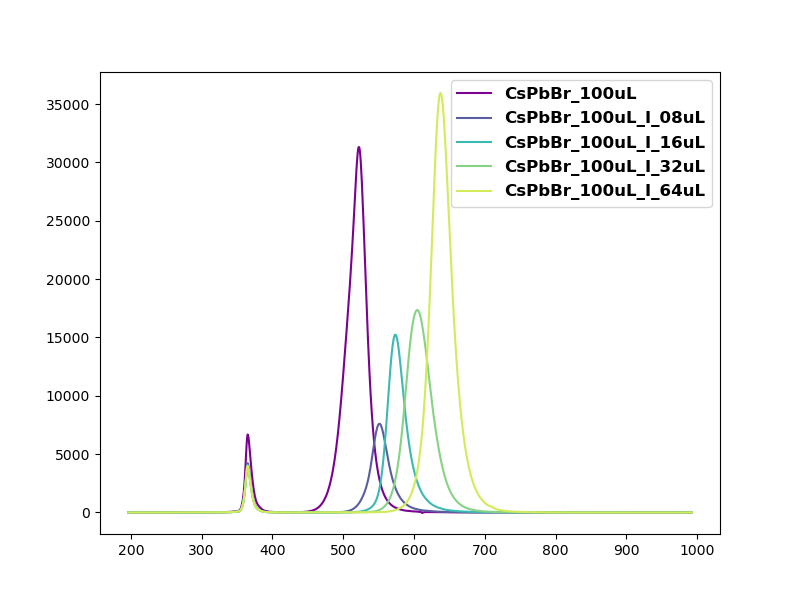

In [44]:
## Plot average PL profiles in each subfolder
f2, ax2 = plt.subplots(1, 1, figsize = (8, 6))
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

k = len(subfolder)
color_idx = np.linspace(0, 1, k)
for i in range(len(subfolder)):
    #ax2.set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})
    ax2.plot(df.wavelength, getattr(df, os.path.basename(subfolder[i])), color=cmap(color_idx[i]), label=os.path.basename(subfolder[i]))

legend_properties = {'weight':'bold', 'size':12}    
ax2.legend(fontsize=legendsize, prop=legend_properties)

In [45]:
## Fit PL peaks by 1 Gaussian distribution
## http://hyperphysics.phy-astr.gsu.edu/hbase/Math/gaufcn2.html
## https://en.wikipedia.org/wiki/Cauchy_distribution


def _1gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))


def _1Lorentz(x, A, x0, sigma):
    return A*sigma**2/((x-x0)**2+sigma**2)


def _1peak_fit_PL(x, y, distr='G', plot=False, plot_title=None, maxfev=100000):    
    # 'G': Guassian
    # 'L': Lorentz        
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    if distr == 'G':
        popt, pcov = curve_fit(_1gauss, x, y, p0=[max(y), mean, sigma], maxfev=maxfev)
    else:
        popt, pcov = curve_fit(_1Lorentz, x, y, p0=[max(y), mean, sigma], maxfev=maxfev)
    
    A = popt[0]
    x0 = popt[1]
    sigma = popt[2]
    
    if distr == 'G':
        fitted_result = _1gauss(x, *popt)
        fit_model = 'Gaussian'
    else:
        fitted_result = _1Lorentz(x, *popt)
        fit_model = 'Lorentz'
    
    #fitted_result = _1gauss(x, *popt)
    residulas = y - fitted_result
    ss_res = np.sum(residulas**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_2 = 1 - (ss_res / ss_tot)
    r2 = f'R\u00b2={r_2:.2f}'
    
    if plot == True:
        plt.figure()
        plt.plot(x,y,'b+:',label='data')
        plt.plot(x,fitted_result,'ro:',label='Total fit\n'+r2)
        plt.legend()
        plt.title(f'{fit_model} : {plot_title}')
        plt.show()
    else: pass
    
    return popt, r_2


In [46]:
## Fit PL peaks by Multi Gaussian distributions
## http://hyperphysics.phy-astr.gsu.edu/hbase/Math/gaufcn2.html

def _2gauss(x, A1, x1, s1, A2, x2, s2):
    return (_1gauss(x, A1, x1, s1) +
            _1gauss(x, A2, x2, s2))


def _3gauss(x, A1, x1, s1, A2, x2, s2, A3, x3, s3):
    return (_1gauss(x, A1, x1, s1) +
            _1gauss(x, A2, x2, s2) + 
            _1gauss(x, A3, x3, s3))


def _2Lorentz(x, A1, x1, s1, A2, x2, s2):
    return (_1Lorentz(x, A1, x1, s1) +
            _1Lorentz(x, A2, x2, s2))


def _3Lorentz(x, A1, x1, s1, A2, x2, s2, A3, x3, s3):
    return (_1Lorentz(x, A1, x1, s1) +
            _1Lorentz(x, A2, x2, s2) +
            _1Lorentz(x, A3, x3, s3))


def _2peak_fit_PL(x, y, distr='G', height=930, plot=False, plot_title=None, second_peak=3, maxfev=100000):
    # 'G': Guassian
    # 'L': Lorentz  
    peaks, _ = find_peaks(y, height=height)
    if len(peaks) >2:
        raise IndexError('Number of peaks should be less than 2.')
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    
    if len(peaks) == 2:
        if distr == 'G':
            popt, pcov = curve_fit(_2gauss, x, y, p0=[y[peaks[0]], x[peaks[0]], sigma, y[peaks[-1]], x[peaks[-1]], sigma], maxfev=maxfev)
        else:
            popt, pcov = curve_fit(_2Lorentz, x, y, p0=[y[peaks[0]], x[peaks[0]], sigma, y[peaks[-1]], x[peaks[-1]], sigma], maxfev=maxfev)
    else:
        if distr == 'G':
            popt, pcov = curve_fit(_2gauss, x, y, p0=[y[peaks[0]], x[peaks[0]], sigma, y[peaks[0]]/abs(second_peak), x[peaks[0]]-second_peak*sigma, sigma], maxfev=maxfev)
        else:
            popt, pcov = curve_fit(_2Lorentz, x, y, p0=[y[peaks[0]], x[peaks[0]], sigma, y[peaks[0]]/abs(second_peak*sigma), x[peaks[0]]-second_peak*sigma, sigma], maxfev=maxfev)
    #A = popt[0]
    #x0 = popt[1]
    #sigma = popt[2]
    
    pars_1 = popt[0:3]
    pars_2 = popt[3:6]
    
    if distr == 'G':
        peak_1 = _1gauss(x, *pars_1)
        peak_2 = _1gauss(x, *pars_2)
        fit_model = 'Gaussian'
    else:
        peak_1 = _1Lorentz(x, *pars_1)
        peak_2 = _1Lorentz(x, *pars_2)
        fit_model = 'Lorentz'
    
    fitted_result = _2gauss(x, *popt)
    residulas = y - fitted_result
    ss_res = np.sum(residulas**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_2 = 1 - (ss_res / ss_tot)
    r2 = f'R\u00b2={r_2:.2f}'
    
    if plot == True:
        plt.figure()
        plt.plot(x,y,'b+:',label='data')
        plt.plot(x,fitted_result,'ro:',label='Total fit\n'+r2)
        
        # peak 1
        plt.plot(x, peak_1, "g", label='peak 1')
        plt.fill_between(x, peak_1.min(), peak_1, facecolor="green", alpha=0.5)
  
        # peak 2
        plt.plot(x, peak_2, "y", label='peak 2')
        plt.fill_between(x, peak_2.min(), peak_2, facecolor="yellow", alpha=0.5)  
        
        plt.title(f'{fit_model} : {plot_title}')
        plt.legend()
        plt.show()
    else: pass
    
    return popt, r_2

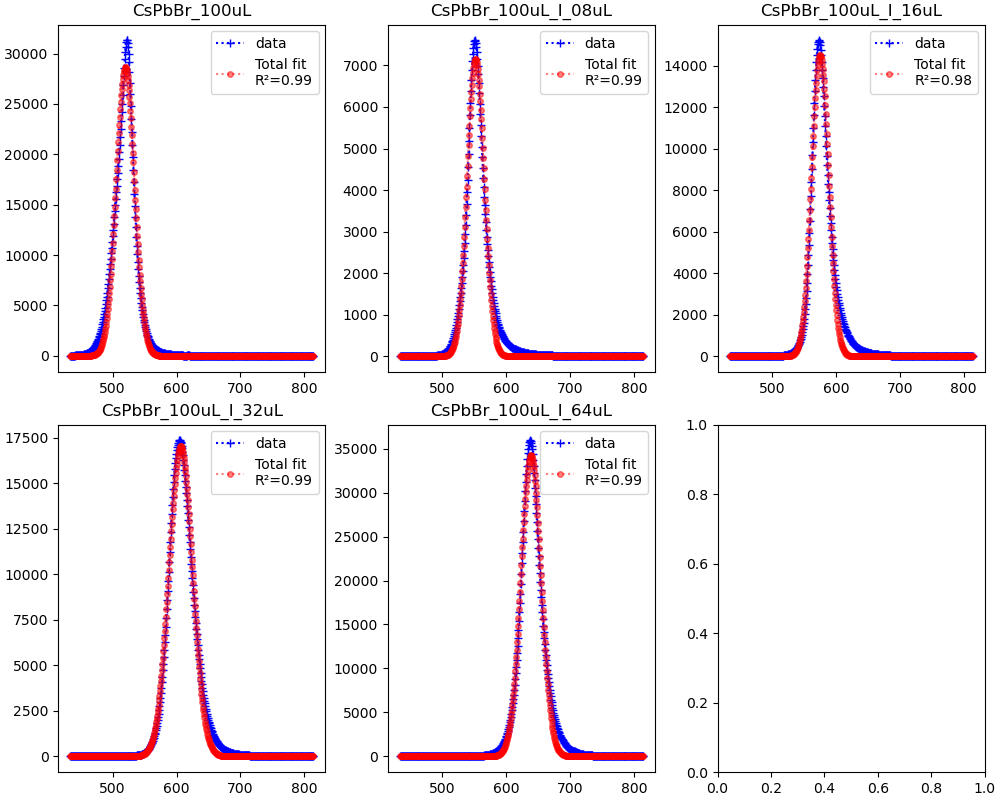

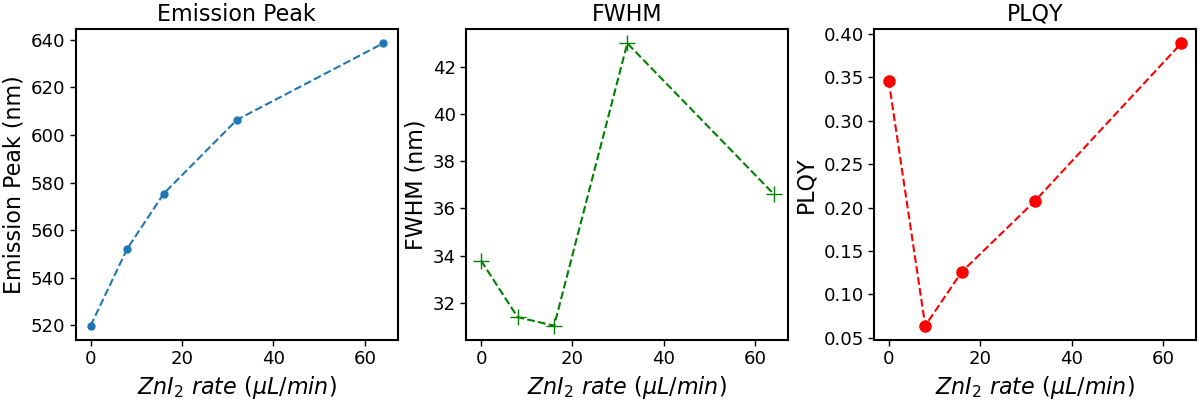

In [104]:
## 1 Gaussian peak fittimg

f3, ax3 = plt.subplots(2, int(len(subfolder)/2)+1, figsize = (10, 8), constrained_layout=True)
ax3 = ax3.flatten()
w1 = 300
w2 = 800

peak = []
fwhm = []
simpson_int = []

for i in range(len(subfolder)):
    #i = 4
    x = np.array(df[w1:w2].wavelength)
    y = np.array(getattr(df[w1:w2], os.path.basename(subfolder[i])))
    #_2peak_fit_PL(x,y, distr='G', height=1000, second_peak=-4, plot=True, plot_title=os.path.basename(subfolder[i]))
    popt, r_2 = _1peak_fit_PL(x,y, distr='G')
    
    simpson_int.append(integrate.simpson(y,x))
    peak.append(popt[1])
    fwhm.append(2.355*popt[2])
    
    
    r2 = f'R\u00b2={r_2:.2f}'
    fitted_result = _1gauss(x, *popt)
    ax3[i].set_title(os.path.basename(subfolder[i]))
    ax3[i].plot(x,y,'b+:',label='data')
    ax3[i].plot(x,fitted_result,'ro:',label='Total fit\n'+r2, alpha=0.5, markersize=4)
    ax3[i].legend()


abs_365 = np.asarray([1.8632, 2.4142, 2.4448, 2.3093, 2.1596])
abs_365_r = 0.046383
plqy_r = 0.94
ref_idx_toluene = 1.506
ref_idx_etoh = 1.3614
integral_r = 89717.50186416409 #59741.143
integral_pqds = np.asarray(simpson_int)

plqy = plqy_r*abs_365_r*(ref_idx_toluene**2)*integral_pqds / (integral_r*(ref_idx_etoh**2)*abs_365)
    
f4, ax4 = plt.subplots(1, 3, figsize = (12, 4), constrained_layout=True)

labelsize = 16
ax4[0].set_title('Emission Peak', fontdict={'size': labelsize})
ax4[0].plot([0,8,16,32,64], peak, '.--', markersize=10)
ax4[0].set_xlabel(r'$ZnI_2\ rate\ (\mu L/min)$', fontdict={'size': labelsize})
ax4[0].set_ylabel('Emission Peak (nm)', fontdict={'size': labelsize})

ax4[1].set_title('FWHM', fontdict={'size': labelsize})
ax4[1].plot([0,8,16,32,64], fwhm, 'g+--', markersize=12)
ax4[1].set_xlabel(r'$ZnI_2\ rate\ (\mu L/min)$', fontdict={'size': labelsize})
ax4[1].set_ylabel('FWHM (nm)', fontdict={'size': labelsize})

ax4[2].set_title('PLQY', fontdict={'size': labelsize})
ax4[2].plot([0,8,16,32,64], plqy, 'ro--', markersize=8)
ax4[2].set_xlabel(r'$ZnI_2\ rate\ (\mu L/min)$', fontdict={'size': labelsize})
ax4[2].set_ylabel('PLQY', fontdict={'size': labelsize})

for i in range(len(ax4)):    
    # ax4.set_xlim(440, 750)
    # ax4.set_ylim(-0.05, 1.2)
    # ax4.set_xlabel('Wavelength (nm)', fontsize=16, fontweight='regular')
    # ax4.set_ylabel('PL Intensity Norm.', fontsize=16, fontweight='regular')
    ax4[i].tick_params(axis='both', direction='out', labelsize=13, size=4, width=1)
    spinewidth = 1.5
    ax4[i].spines["bottom"].set_linewidth(spinewidth)
    ax4[i].spines["right"].set_linewidth(spinewidth)
    ax4[i].spines["top"].set_linewidth(spinewidth)
    ax4[i].spines["left"].set_linewidth(spinewidth)

imag_name = '20220630_PL_CsPbBr_I_03.png'
plt.savefig(cwd + '/' + imag_name, dpi = 300,  transparent=True)

In [48]:
popt

array([3.42406362e+04, 6.38587119e+02, 1.55484171e+01])

In [111]:
fwhm2

[16.628627811704426,
 50.45514936924236,
 46.77826314601626,
 54.63647004628093,
 -53.55798621913768]

In [112]:
for i in range(len(peak1)):
    if peak1[i] > peak2[i]:
        a, b = peak1[i], peak2[i]
        peak1[i], peak2[i] = b, a
        c, d = fwhm1[i], fwhm2[i]
        fwhm1[i], fwhm2[i] = d, c

In [113]:
peak2

[523.278665388955,
 555.9142235158547,
 584.8020135786392,
 614.6615150160927,
 642.8160666460287]

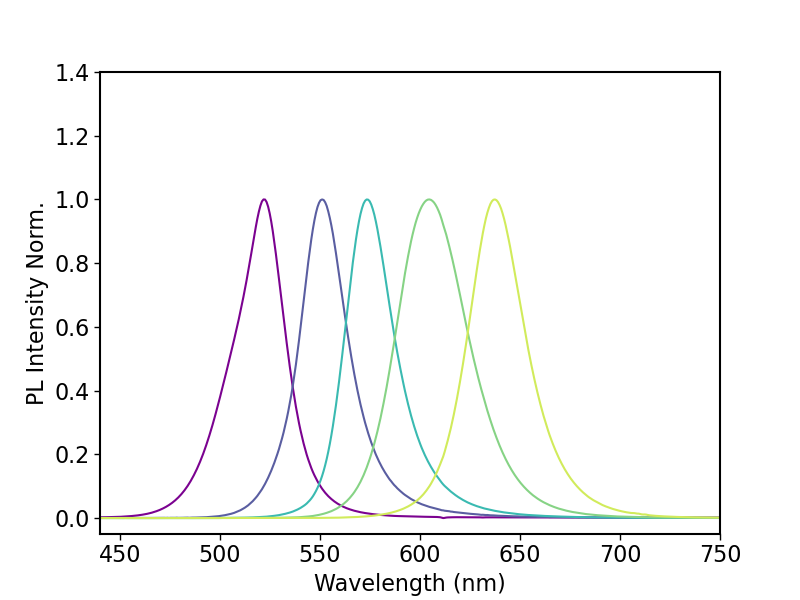

In [100]:
## Plot Normalized (by Max-min) PL profiles in each subfolder
f5, ax5 = plt.subplots(1, 1, figsize = (8, 6))
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})


# mpld3.disable_notebook()
label = ['CsPbBr', 'CsPbBr_I_08uL', 'CsPbBr_I_16uL', 'CsPbBr_I_32uL', 'CsPbBr_I_64uL']
k = len(subfolder)
color_idx = np.linspace(0, 1, k)
for i in range(len(subfolder)):
    #ax2.set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})
    ax5.plot(df_norm2.wavelength, getattr(df_norm2, os.path.basename(subfolder[i])), color=cmap(color_idx[i]), label=label[i])

legend_properties = {'weight':'bold', 'size':12}    
# ax5.legend(prop=legend_properties)

ax5.set_xlim(440, 750)
ax5.set_ylim(-0.05, 1.4)
ax5.set_xlabel('Wavelength (nm)', fontsize=16, fontweight='regular')
ax5.set_ylabel('PL Intensity Norm.', fontsize=16, fontweight='regular')
ax5.tick_params(axis='both', direction='out', labelsize=16, size=4, width=1)
spinewidth = 1.5
ax5.spines["bottom"].set_linewidth(spinewidth)
ax5.spines["right"].set_linewidth(spinewidth)
ax5.spines["top"].set_linewidth(spinewidth)
ax5.spines["left"].set_linewidth(spinewidth)

imag_name = '20220630_PL_CsPbBr_I_02.png'
plt.savefig(cwd + '/' + imag_name, dpi = 300,  transparent=True)